In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import numpy as np
import allel
import itertools
import os
from subprocess import call
from tqdm import tqdm, trange

import statsmodels.api as sm
import statsmodels.formula.api as smf

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #allows multiple outputs

#### Step 1: make contig list

In [28]:
#First make contig list
contig_list = pd.read_table('/data3/arshad_PNAS_data/For_Tae/polistes_contig.txt', sep=',', header=None)
contig_list.rename(columns ={0:"ID", 1:"Length"}, inplace =True)
contig_list.head(5)

,ID,Length
0,##contig=<ID=PdomSCFr1.2-0001,length=7126315>
1,##contig=<ID=PdomSCFr1.2-0002,length=5803805>
2,##contig=<ID=PdomSCFr1.2-0003,length=6052460>
3,##contig=<ID=PdomSCFr1.2-0004,length=5611376>
4,##contig=<ID=PdomSCFr1.2-0005,length=4881697>


In [29]:
contig_list['ID'] = contig_list['ID'].str.split('ID=').str.get(1)
contig_list['Length'] = contig_list['Length'].str.split('=').str.get(1)
contig_list['Length'] = contig_list['Length'].str.split('>').str.get(0).astype(int)
contig_list.head(3)
contig_list.dtypes

,ID,Length
0,PdomSCFr1.2-0001,7126315
1,PdomSCFr1.2-0002,5803805
2,PdomSCFr1.2-0003,6052460


ID        object
Length     int64
dtype: object

In [30]:
contig_list['Length'].sort_values(ascending=False)

0       7126315
2       6052460
1       5803805
3       5611376
4       4881697
5       3858427
7       3797714
6       3730956
8       3621605
9       3609360
11      2824937
10      2725388
12      2599059
13      2573728
18      2453237
14      2413543
15      2413410
16      2398943
17      2325882
21      2238456
19      2235455
20      2188473
22      2170035
24      2121827
25      1992428
23      1985952
28      1960961
27      1946622
26      1867107
29      1859493
         ...   
1467       1072
1435       1068
1456       1065
1449       1064
1471       1060
1472       1057
1444       1050
1466       1043
1474       1040
1461       1040
1475       1039
1464       1038
1476       1036
1462       1033
1459       1032
1477       1030
1469       1028
1448       1024
1454       1023
1453       1022
1478       1022
1447       1021
1468       1011
1481       1006
1458       1001
1457        980
1480        970
1479        965
1470        959
1473        949
Name: Length, Length: 14

In [31]:
contig_plus10k = contig_list[contig_list['Length'] > 100000] #remove anything smaller than single window
contig_plus10k['Length'].sort_values()

210     101493
203     101755
223     102777
217     105230
204     105966
206     106050
207     106806
211     108909
196     110474
198     111096
212     114859
195     116309
200     117118
202     120574
205     124790
201     127201
209     128207
214     128440
188     131519
194     133356
192     133421
197     134140
199     143383
191     145379
184     147245
193     149421
185     151474
182     154311
179     157241
177     162148
        ...   
29     1859493
26     1867107
27     1946622
28     1960961
23     1985952
25     1992428
24     2121827
22     2170035
20     2188473
19     2235455
21     2238456
17     2325882
16     2398943
15     2413410
14     2413543
18     2453237
13     2573728
12     2599059
10     2725388
11     2824937
9      3609360
8      3621605
6      3730956
7      3797714
5      3858427
4      4881697
3      5611376
1      5803805
2      6052460
0      7126315
Name: Length, Length: 215, dtype: int64

In [32]:
#Output the File
#Do it once! only once!
#contig_plus10k['ID'].to_csv('/home/taeyoon/VcfFiles/LdByWindow/pol_contig_list.txt', header=False, index=False)

#### Step 2: Chop by 10k window

In [ ]:
#this step uses tabix
#this first requires turning vcf to vcf.gz
# bgzip your.vcf
# tabix -p vcf your.vcf.gz <- this makes index
# tabix your.vcf.gz chr1:10,000,000-20,000,000

#modify chopbywindow.script.txt (is in VcfFiles/LdByWindows)
#this chops them into 10k windows, deposites the output into set directory

#for window of LD test in chopped files, going with 60 for safe measure.
#No MAF cut as per original and purpose
#polistes has to run in geno-r2 (NOT hap-r2)


#### Step 3: Calculating Mean-Median R2 per Window

In [42]:
#take all files and make one dataframe
ld_r2 = []

path_folder = '/data3/TaeFile/Pol_HapLd/'

for file in tqdm(os.listdir(path_folder), total=len(path_folder)):
    window = file.split('_headered')[0]
    df = pd.read_csv(f'{path_folder}/{file}', sep='\t')
    mean_r2 = df['R^2'].mean()
    median_r2 = df['R^2'].median()
    ld_r2.append([window, mean_r2, median_r2])
#     df.drop(columns = ['N_CHR', 'D', 'Dprime'], inplace=True)
#     ld_r2.append(df)
# cut_r2 = pd.concat(ld_r2)
# cut_r2.to_csv('/home/taeyoon/VcfFiles/LdByWindow/pol_windowed_LD.csv', index=False)

#destination of the final file is in home directory = windowed_LD.csv
#condition, hap.ld, with maf 0.2, and window of 80 bp

2096it [00:08, 254.26it/s]                      


In [43]:
df = pd.DataFrame(ld_r2, columns = ['ID', 'r2_mean', 'r2_median'])
display(df.head())

,ID,r2_mean,r2_median
0,PdomSCFr1.2-0173_100000,0.246808,0.079546
1,PdomSCFr1.2-0115_200000,0.251666,0.092593
2,PdomSCFr1.2-0030_300000,0.396516,0.200820
3,PdomSCFr1.2-0025_2000000,0.335720,0.111111
4,PdomSCFr1.2-0034_1400000,0.252937,0.079365


In [55]:
# path_folder_2 = '/data3/TaeFile/Pol_HeaderedVcf/'

# for file in tqdm(os.listdir(path_folder_2), total=len(path_folder_2)):
#     df_basket = pd.read_table(f'{path_folder_2}/{file}', sep ='\t', header=None, comment='#')

#     df_basket.rename(columns={
#     0:"SCAF", 1:"POS", 2:"Id", 3:"REF", 4:"ALT", 5:"quality", 6:"filter", 7:"INFO", 8:"header", 
#     9:"1", 10:"10", 11:"11", 12:"2b", 13:"3", 14:"4", 15:"5", 16:"6", 17:"7", 18:"8"}, inplace=True)
    
#     column_picks= ["SCAF", "POS", "REF", "ALT", "INFO"]
#     df_basket_picks = df_basket[column_picks]

2096it [00:32, 63.99it/s]                      


In [56]:
# df_basket_picks.head(5)

,SCAF,POS,REF,ALT,INFO
0,PdomSCFr1.2-0049,900052,T,C,AC=1;AF=0.050;AN=20;BaseQRankSum=1.82;Clipping...
1,PdomSCFr1.2-0049,900111,C,T,AC=1;AF=0.050;AN=20;BaseQRankSum=0.817;Clippin...
2,PdomSCFr1.2-0049,900124,G,A,AC=1;AF=0.050;AN=20;BaseQRankSum=0.994;Clippin...
3,PdomSCFr1.2-0049,900171,G,T,AC=9;AF=0.450;AN=20;BaseQRankSum=0.289;Clippin...
4,PdomSCFr1.2-0049,900215,T,A,AC=2;AF=0.100;AN=20;BaseQRankSum=0.711;Clippin...


#### Step 4: Making the Master Dataframe

In [49]:
#Mutation direction function "strength_classifier"
strong_bases= ['G', 'C']
weak_bases= ['A', 'T']

def strength_classifier(ancestor, derived):
    if (ancestor in strong_bases) and (derived in weak_bases):
        return 'SW'
    elif (ancestor in weak_bases) and (derived in strong_bases):
        return 'WS'
    else:
        return 'NN'

In [50]:
#split_bar = Trimmed_table(Trimmed_table['Alt_Freq' == 0.1], Trimmed_table['Strength' == 'SW'])
#Trimmed_table['Strength'].value_counts().plot(kind='bar')
#Ancestry based on allele frequency

def barcoder(strength, frequency):
    if (strength == 'SW') and (frequency == 0.1):
        return 'SW-Rare'
    elif (strength == 'SW') and (frequency >= 0.5):
        return 'SW-Common'
    elif (strength == 'WS') and (frequency == 0.1):
        return 'WS-Rare'
    elif (strength == 'WS') and (frequency >= 0.5):
        return 'WS-Common'
    else:
        return 'NaN'

    '''Rare mutation defined as something with frequency of 0.1,
        Common mutation is something that is found more than 0.5 of the time.'''

In [51]:
def barcoder(strength, frequency):
    if (strength == 'SW') and (frequency == 0.1):
        return 'SW-Rare'
    elif (strength == 'SW') and (frequency >= 0.5):
        return 'SW-Common'
    elif (strength == 'WS') and (frequency == 0.1):
        return 'WS-Rare'
    elif (strength == 'WS') and (frequency >= 0.5):
        return 'WS-Common'
    else:
        return 'NaN'

    '''Rare mutation defined as something with frequency of 0.1,
        Common mutation is something that is found more than 0.5 of the time.'''

In [52]:
#AA caller, based on frequency.
def AA_caller(frequency, reference, alternative):
    if (frequency > 0.5):
        return alternative
    elif (frequency < 0.5):
        return reference
    else:
        return np.nan

In [79]:
chopped_polistes = []

path_folder_2 = '/data3/TaeFile/Pol_HeaderedVcf'

for file in tqdm(os.listdir(path_folder_2), total=len(path_folder_2)):
    window = file.split('_headered')[0]
    
    # Process the file
    df_basket = pd.read_table(f'{path_folder_2}/{file}', sep ='\t', header=None, comment='#')
    df_basket.rename(columns={
        0:"SCAF", 
        1:"POS", 
        2:"Id", 
        3:"REF", 
        4:"ALT", 
        5:"quality", 
        6:"filter", 
        7:"INFO", 
        8:"header", 
        9:"1", 10:"10", 11:"11", 12:"2b", 13:"3", 14:"4", 15:"5", 16:"6", 17:"7", 18:"8"}, 
                     inplace=True)
    column_picks= ["SCAF", "POS", "REF", "ALT", "INFO"]
    df_basket_picks = df_basket[column_picks]
    
    # Get Allele Frequency
    df_basket_picks['AF'] = df_basket_picks['INFO'].str.split('AF=').str.get(1).str.split(';').str.get(0).astype(float)
    df_basket_picks.drop(columns=['INFO'], inplace=True)
    
    #AA base calling
    df_basket_picks["AA"] = df_basket_picks.apply(lambda row: AA_caller(row["AF"], row["REF"], row["ALT"]), 
                                                  axis= 'columns')
    df_basket_picks["Derived"] = df_basket_picks.apply(lambda row: AA_caller(row["AF"], row["ALT"], row["REF"]), 
                                                       axis= 'columns')
    
    #Mutation direction
    df_basket_picks['Dirct'] = df_basket_picks.apply(lambda row: strength_classifier(row['REF'], row['ALT']), 
                                                         axis='columns')
    
    df_basket_picks['Barcode'] = df_basket_picks.apply(lambda row: barcoder(row['Dirct'], row['AF']), axis='columns')
    #Barcoded_Wasp = df_basket_picks[df_basket_picks['Barcode'] != 'NaN'] #drop anything NaN <- this tosses NN
    #this also got rid of any WS and SW that fell in 0.2 and 0.4 freq window. Now it keeps it all. = better
    Barcoded_Wasp = df_basket_picks #maintain variable transition so that I don't have to touch anything downstream
    
    # dr.kent's stats
    SW_Total_freq = (Barcoded_Wasp['Dirct'].values == 'SW').sum()
    WS_Total_freq = (Barcoded_Wasp['Dirct'].values == 'WS').sum()
    NN_Total_freq = (Barcoded_Wasp['Dirct'].values == 'NN').sum()
    SNP_Total = SW_Total_freq + WS_Total_freq + NN_Total_freq
    
    SW_Rare_freq = (Barcoded_Wasp['Barcode'].values == 'SW-Rare').sum()
    WS_Rare_freq = (Barcoded_Wasp['Barcode'].values == 'WS-Rare').sum()
    
    SW_Common_freq = (Barcoded_Wasp['Barcode'].values == 'SW-Common').sum()
    WS_Common_freq = (Barcoded_Wasp['Barcode'].values == 'WS-Common').sum()
    
    chopped_polistes.append([window, SW_Total_freq, WS_Total_freq, NN_Total_freq, SNP_Total, SW_Rare_freq, WS_Rare_freq, 
                            SW_Common_freq, WS_Common_freq])

  0%|          | 0/30 [00:00<?, ?it/s]/home/taeyoon/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/taeyoon/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/taeyoon/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

In [80]:
final_file = pd.DataFrame(chopped_polistes)
final_file.head()

,0,1,2,3,4,5,6,7,8
0,PdomSCFr1.2-0158_100000,834,554,404,1792,160,61,108,118
1,PdomSCFr1.2-0024_0,176,126,78,380,21,13,31,40
2,PdomSCFr1.2-0001_5500000,499,322,216,1037,93,50,69,83
3,PdomSCFr1.2-0157_0,173,88,68,329,11,1,4,13
4,PdomSCFr1.2-0038_1300000,953,686,517,2156,163,84,148,175


In [81]:
final_file.rename(columns={
        0:"ID", 
        1:"SW_Total", 2:"WS_Total", 3:"NN_Total", 4: "SNP_Total",
        5:"SW_Rare", 6:"WS_Rare", 7:"SW_Common", 8:"WS_Common",}, inplace=True)

#W_Total_freq, WS_Total_freq, NN_Total_freq, SNP_Total, SW_Rare_freq, WS_Rare_freq, SW_Common_freq, WS_Common_freq

In [82]:
final_file.head(5)

,ID,SW_Total,WS_Total,NN_Total,SNP_Total,SW_Rare,WS_Rare,SW_Common,WS_Common
0,PdomSCFr1.2-0158_100000,834,554,404,1792,160,61,108,118
1,PdomSCFr1.2-0024_0,176,126,78,380,21,13,31,40
2,PdomSCFr1.2-0001_5500000,499,322,216,1037,93,50,69,83
3,PdomSCFr1.2-0157_0,173,88,68,329,11,1,4,13
4,PdomSCFr1.2-0038_1300000,953,686,517,2156,163,84,148,175


In [75]:
#Start Merging R2 dataframe with the 'final file'
Chopped_Polistes = df.merge(final_file, on='ID')
Chopped_Polistes.head(5)

,ID,r2_mean,r2_median,SW_Total,WS_Total,SW_Rare,WS_Rare,SW_Common,WS_Common
0,PdomSCFr1.2-0173_100000,0.246808,0.079546,195,178,113,73,82,105
1,PdomSCFr1.2-0115_200000,0.251666,0.092593,244,225,126,87,118,138
2,PdomSCFr1.2-0030_300000,0.396516,0.200820,55,53,39,36,16,17
3,PdomSCFr1.2-0025_2000000,0.335720,0.111111,237,194,146,89,91,105
4,PdomSCFr1.2-0034_1400000,0.252937,0.079365,170,161,113,57,57,104


In [83]:
test = final_file[final_file['ID'] == 'PdomSCFr1.2-0173_100000'] #checking if it paired up correctly
test.head()

,ID,SW_Total,WS_Total,NN_Total,SNP_Total,SW_Rare,WS_Rare,SW_Common,WS_Common
1717,PdomSCFr1.2-0173_100000,688,456,327,1471,113,73,82,105


### Output

In [84]:
#Run only once!
#Chopped_Polistes.to_csv('/home/taeyoon/VcfFiles/LdByWindow/PolistesSFiles/Chopped_Polistes.csv', index=False)

In [4]:
Open_Polistes = pd.read_csv('/home/taeyoon/VcfFiles/LdByWindow/PolistesSFiles/Chopped_Polistes.csv')
Open_Polistes.head(8)

,ID,r2_mean,r2_median,SW_Total,WS_Total,SW_Rare,WS_Rare,SW_Common,WS_Common
0,PdomSCFr1.2-0173_100000,0.246808,0.079546,195,178,113,73,82,105
1,PdomSCFr1.2-0115_200000,0.251666,0.092593,244,225,126,87,118,138
2,PdomSCFr1.2-0030_300000,0.396516,0.200820,55,53,39,36,16,17
3,PdomSCFr1.2-0025_2000000,0.335720,0.111111,237,194,146,89,91,105
4,PdomSCFr1.2-0034_1400000,0.252937,0.079365,170,161,113,57,57,104
5,PdomSCFr1.2-0124_0,0.322876,0.111111,298,262,160,93,138,169
6,PdomSCFr1.2-0033_1400000,0.403644,0.166667,244,228,141,96,103,132
7,PdomSCFr1.2-0052_1000000,0.234617,0.061728,155,85,105,25,50,60


### S1: Looking at Total numbers

In [ ]:
#https://www.ncbi.nlm.nih.gov/genome/?term=polistes+dominula%5Borgn%5D
#Polistes dominula (european paper wasp)
#GC% 31.5% (AT will be 68.5%), compare to B.imp 37.9%, it's a little lower.

In [5]:
#First, adding GC% adjusted values to the dataframe.
Open_Polistes['SW_adjusted'] = (Open_Polistes['SW_Total']/0.315) #target prevalence adjusted values
Open_Polistes['WS_adjusted'] = (Open_Polistes['WS_Total']/0.685)
Open_Polistes['WS/SW'] = Open_Polistes['WS_adjusted'] / Open_Polistes['SW_adjusted']

In [6]:
Open_Polistes.head(5)
len(Open_Polistes)

,ID,r2_mean,r2_median,SW_Total,WS_Total,SW_Rare,WS_Rare,SW_Common,WS_Common,SW_adjusted,WS_adjusted,WS/SW
0,PdomSCFr1.2-0173_100000,0.246808,0.079546,195,178,113,73,82,105,619.047619,259.854015,0.419764
1,PdomSCFr1.2-0115_200000,0.251666,0.092593,244,225,126,87,118,138,774.603175,328.467153,0.424046
2,PdomSCFr1.2-0030_300000,0.396516,0.200820,55,53,39,36,16,17,174.603175,77.372263,0.443132
3,PdomSCFr1.2-0025_2000000,0.335720,0.111111,237,194,146,89,91,105,752.380952,283.211679,0.376421
4,PdomSCFr1.2-0034_1400000,0.252937,0.079365,170,161,113,57,57,104,539.682540,235.036496,0.435509


2096

In [7]:
#name the the final table to work with x, drop possible NaNs
x = Open_Polistes.dropna()
len(x) #pre-dropna is 2096, post treatment is 2095, one Nan dropped.

2095

<Figure size 1152x432 with 0 Axes>

(0, 500)

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


LinregressResult(slope=-40.31241193480284, intercept=173.31094593126582, rvalue=-0.10897986481845721, pvalue=5.731331882530026e-07, stderr=8.037361344670867)

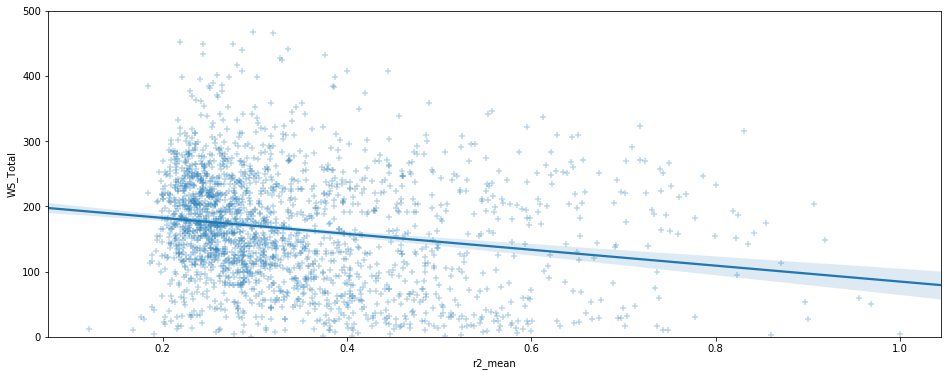

In [98]:
#graph of r2 mean vs WS_Total per window/bins
plt.figure(figsize=(16,6))
plt.ylim(0,500) #there is an outlier going up to near 700 at about r2=0.45, but most stay below 500
sns.regplot(x['r2_mean'], x['WS_Total'], marker="+", scatter_kws={'alpha':0.3})
scipy.stats.linregress(x['r2_median'], x['WS_Total']) #this gives R-value and p-value

<Figure size 1152x432 with 0 Axes>

(0, 500)

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


LinregressResult(slope=-40.31241193480284, intercept=173.31094593126582, rvalue=-0.10897986481845721, pvalue=5.731331882530026e-07, stderr=8.037361344670867)

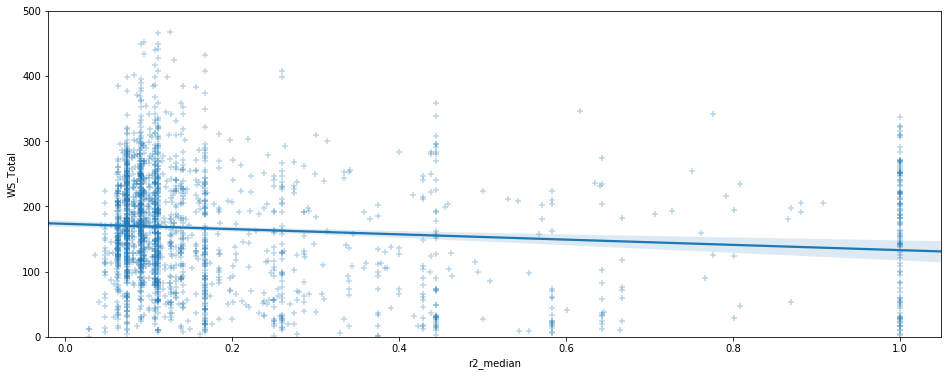

In [99]:
#Same as above but with median r2 per bin
plt.figure(figsize=(16,6))
plt.ylim(0,500)
sns.regplot(x['r2_median'], x['WS_Total'], marker="+", scatter_kws={'alpha':0.3})
scipy.stats.linregress(x['r2_median'], x['WS_Total']) #this gives R-value and p-value

<Figure size 1152x432 with 0 Axes>

(0, 500)

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


LinregressResult(slope=-51.753374675644345, intercept=201.0089472728382, rvalue=-0.12567386810541042, pvalue=7.847427093803416e-09, stderr=8.930013162330916)

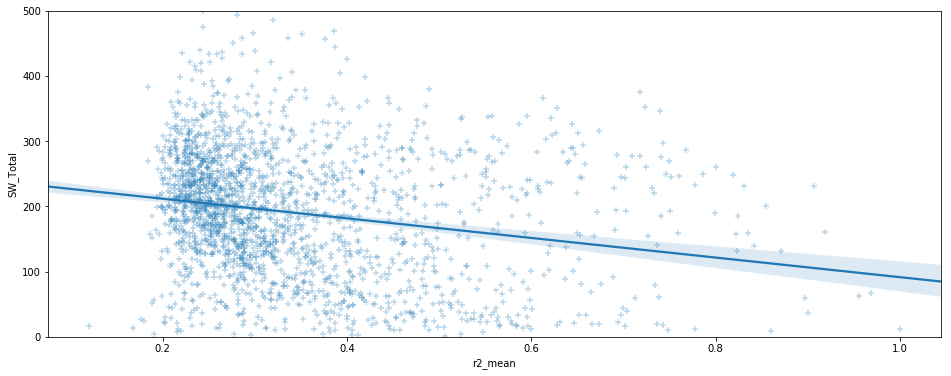

In [101]:
#Plot for SW, the previous ones were WS.
plt.figure(figsize=(16,6))
plt.ylim(0,500)
sns.regplot(x['r2_mean'], x['SW_Total'], marker="+", scatter_kws={'alpha':0.3})
scipy.stats.linregress(x['r2_median'], x['SW_Total']) #this gives R-value and p-value

<Figure size 1152x432 with 0 Axes>

(0, 500)

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


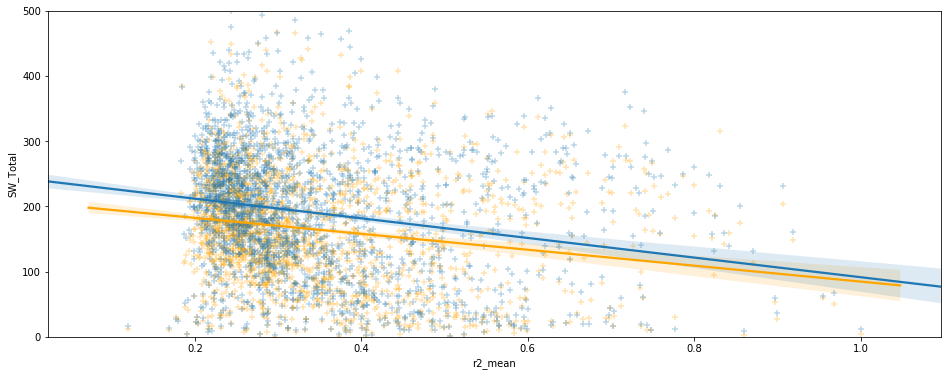

In [106]:
#plot WS and SW together
plt.figure(figsize=(16,6))
plt.ylim(0,500)
sns.regplot(x['r2_mean'], x['WS_Total'], marker="+", scatter_kws={'alpha':0.3}, color = 'orange')
sns.regplot(x['r2_mean'], x['SW_Total'], marker="+", scatter_kws={'alpha':0.3})

<Figure size 1152x432 with 0 Axes>

(0, 1)

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


LinregressResult(slope=0.02081730388756739, intercept=0.393402547925308, rvalue=0.03980498605276893, pvalue=0.06852248619201111, stderr=0.011422418363092813)

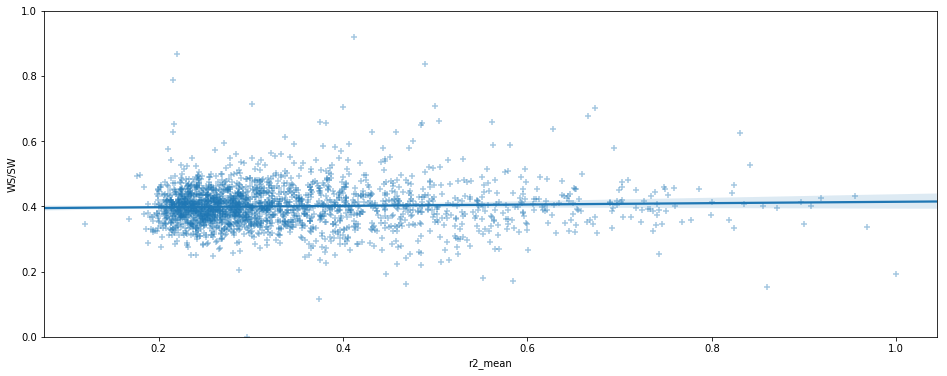

In [109]:
#ratio, WS / SW
plt.figure(figsize=(16,6))
plt.ylim(0,1)
sns.regplot(x['r2_mean'], x['WS/SW'], marker="+", scatter_kws={'alpha':0.4})
scipy.stats.linregress(x['r2_mean'], x['WS/SW'])

<Figure size 1152x432 with 0 Axes>

(0, 1500)

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


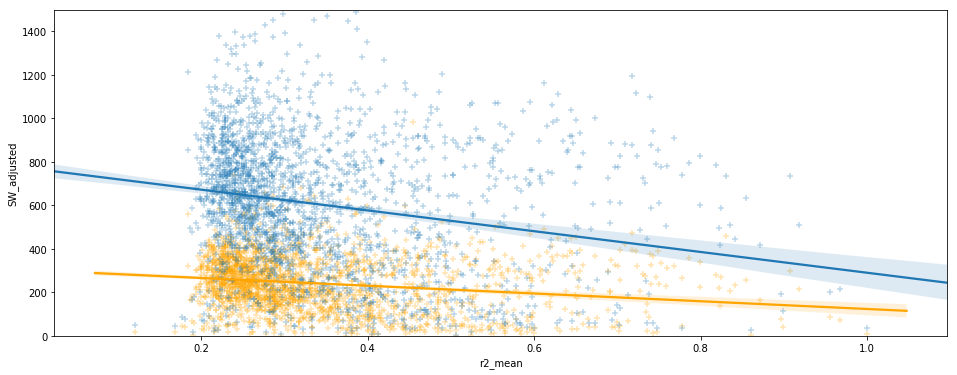

In [113]:
#adjusted as per GC%, ploted together for botht WS and SW.
plt.figure(figsize=(16,6))
plt.ylim(0,1500)
sns.regplot(x['r2_mean'], x['WS_adjusted'], marker="+", scatter_kws={'alpha':0.3}, color='orange')
sns.regplot(x['r2_mean'], x['SW_adjusted'], marker="+", scatter_kws={'alpha':0.3})

### S2: The 10%, Rares

<Figure size 1152x432 with 0 Axes>

(0, 250)

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


LinregressResult(slope=-45.33748801336611, intercept=77.19370289445456, rvalue=-0.16513886870525185, pvalue=2.8190849692368193e-14, stderr=5.918606962987523)

LinregressResult(slope=-107.07531285719662, intercept=147.1187987524179, rvalue=-0.2544733001262696, pvalue=2.544112446974271e-32, stderr=8.89456734800617)

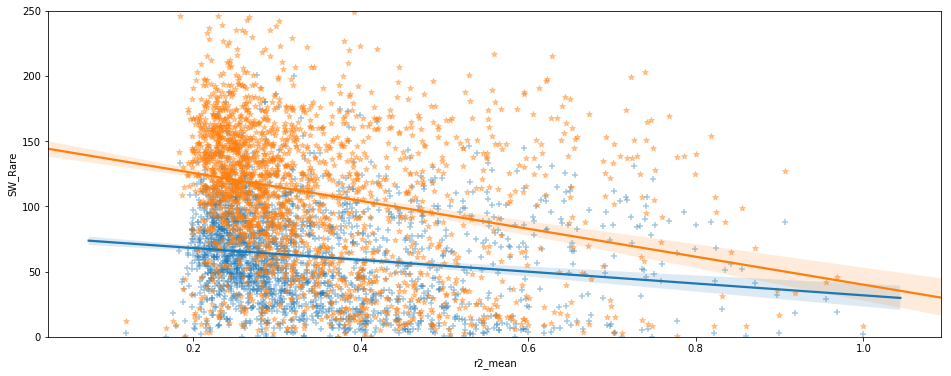

In [116]:
#Plot rare occuring mutations both direction (SW and WS)
plt.figure(figsize=(16,6))
plt.ylim(0,250)
sns.regplot(x['r2_mean'], x['WS_Rare'], marker="+", scatter_kws={'alpha':0.4}) #blue
sns.regplot(x['r2_mean'], x['SW_Rare'], marker="*", scatter_kws={'alpha':0.4}) #orange
scipy.stats.linregress(x['r2_mean'], x['WS_Rare'])
scipy.stats.linregress(x['r2_mean'], x['SW_Rare'])

<Figure size 1152x432 with 0 Axes>

(0, 800)

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


LinregressResult(slope=-66.1861138881257, intercept=112.69153707219644, rvalue=-0.16513886870525188, pvalue=2.81908496923679e-14, stderr=8.640302135748207)

LinregressResult(slope=-339.9216281180845, intercept=467.04380556323144, rvalue=-0.2544733001262696, pvalue=2.544112446974271e-32, stderr=28.23672173970213)

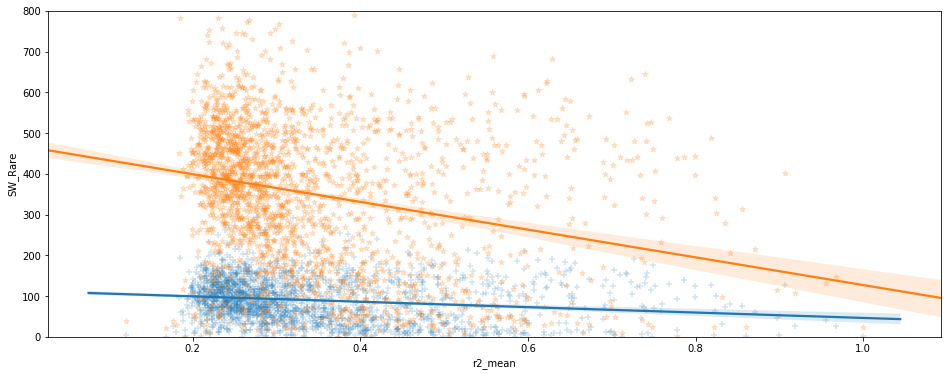

In [119]:
#adjusted for GC%
plt.figure(figsize=(16,6))
plt.ylim(0,800)
sns.regplot(x['r2_mean'], (x['WS_Rare']/0.685), marker="+", scatter_kws={'alpha':0.2}) #blue
sns.regplot(x['r2_mean'], (x['SW_Rare']/0.315), marker="*", scatter_kws={'alpha':0.2}) #orange
scipy.stats.linregress(x['r2_mean'], (x['WS_Rare']/0.685))
scipy.stats.linregress(x['r2_mean'], (x['SW_Rare']/0.315))

### S3: The 50%, Common

<Figure size 1152x432 with 0 Axes>

(0, 300)

(0, 1)

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


LinregressResult(slope=-76.69747304851407, intercept=129.63687659810213, rvalue=-0.18185319110666115, pvalue=4.915293325634385e-17, stderr=9.065106307290929)

LinregressResult(slope=-43.304881218567644, intercept=94.78689962270894, rvalue=-0.11831067879846502, pvalue=5.601701616485284e-08, stderr=7.944513691345216)

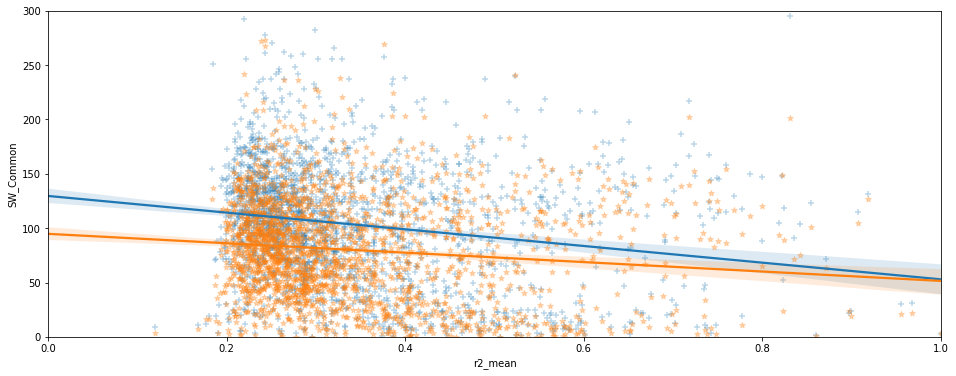

In [125]:
#Common, both directions
plt.figure(figsize=(16,6))
plt.ylim(0,300)
plt.xlim(0,1)
sns.regplot(x['r2_mean'], x['WS_Common'], marker="+", scatter_kws={'alpha':0.3}) #blue
sns.regplot(x['r2_mean'], x['SW_Common'], marker="*", scatter_kws={'alpha':0.3}, ) #orange
scipy.stats.linregress(x['r2_mean'], x['WS_Common'])
scipy.stats.linregress(x['r2_mean'], x['SW_Common'])

<Figure size 1152x432 with 0 Axes>

(0, 500)

(0, 1)

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


LinregressResult(slope=-111.96711393943662, intercept=189.2509147417549, rvalue=-0.18185319110666118, pvalue=4.915293325634385e-17, stderr=13.23373183546121)

LinregressResult(slope=-137.4758133922782, intercept=300.9107924530443, rvalue=-0.11831067879846498, pvalue=5.601701616485305e-08, stderr=25.220678385222914)

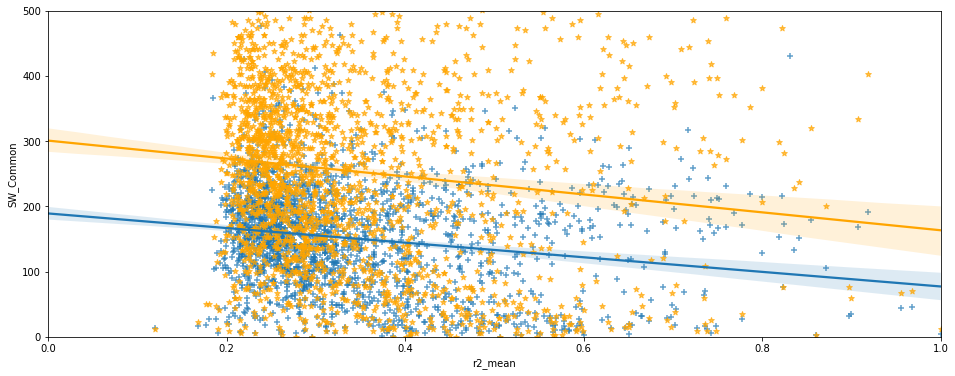

In [167]:
#adjusted for GC%
plt.figure(figsize=(16,6))
plt.ylim(0,500)
plt.xlim(0,1)
sns.regplot(x['r2_mean'], (x['WS_Common']/0.685), marker="+", scatter_kws={'alpha':0.7}) #blue
sns.regplot(x['r2_mean'], (x['SW_Common']/0.315), marker="*", scatter_kws={'alpha':0.7}, color='orange') #orange
scipy.stats.linregress(x['r2_mean'], (x['WS_Common']/0.685))
scipy.stats.linregress(x['r2_mean'], (x['SW_Common']/0.315))

### Extra: Odds Ratio

<Figure size 1152x432 with 0 Axes>

(0, 2.5)

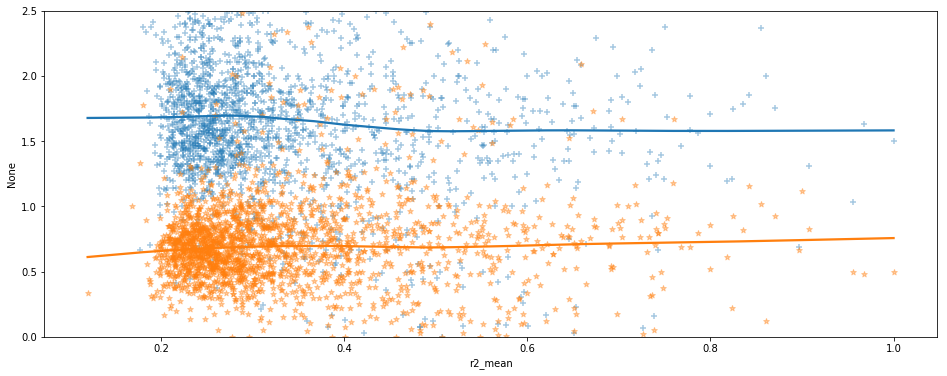

In [8]:
plt.figure(figsize=(16,6))
plt.ylim(0,2.5)
sns.regplot(x['r2_mean'], (x['WS_Common']/x['WS_Rare']), marker="+", scatter_kws={'alpha':0.4}, lowess=True) #blue
sns.regplot(x['r2_mean'], (x['SW_Common']/x['SW_Rare']), marker="*", scatter_kws={'alpha':0.4}, lowess=True) #orange
#note that the lowess option is True, this is non-parametric locally weighted regression line.
#helps with noisy data, this one is noisy.

<Figure size 1152x432 with 0 Axes>

(0, 2)

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


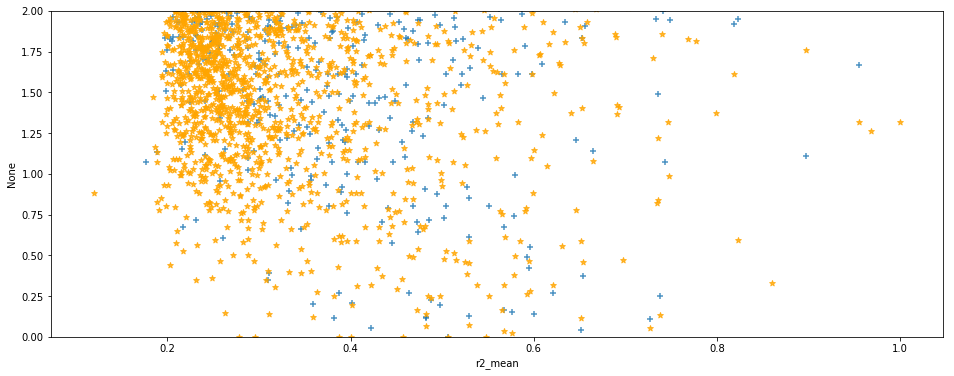

In [163]:
plt.figure(figsize=(16,6))
plt.ylim(0,2)
sns.regplot(x['r2_mean'], (x['WS_Common']/x['WS_Rare'])/0.621, marker="+", fit_reg=True) #blue
sns.regplot(x['r2_mean'], (x['SW_Common']/x['SW_Rare'])/0.379, marker="*", color='orange')
#completely kaput, no line.